<a href="https://colab.research.google.com/github/dashan0313/anycode/blob/master/%E5%9B%BE%E5%83%8F%E5%88%86%E5%89%B2%E6%8A%80%E5%B7%A7_%E5%AD%A6%E4%B9%A0%E7%8E%87%E5%AF%BB%E6%89%BE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image segmentation with CamVid

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [4]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/valid.txt')]

In [5]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

## Data

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0001TP_008730.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f00630.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_010260.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0001TP_009120_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f03960_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0001TP_007920_P.png')]

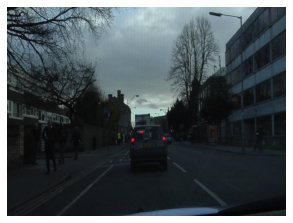

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [9]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

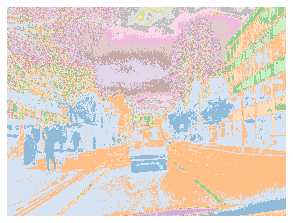

In [10]:
img = open_mask(img_f)
img.show(figsize=(5,5))

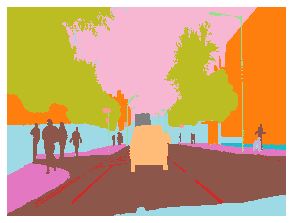

In [11]:
mask = open_mask(get_y_fn(img_f)) #因为本身图片是整数tensor数组，所以不能用open_image打开
mask.show(figsize=(5,5), alpha=1)

In [12]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[26, 26, 26,  ...,  4,  4,  4],
          [26, 26, 26,  ...,  4,  4,  4],
          [26, 26, 26,  ...,  4,  4,  4],
          ...,
          [17, 17, 17,  ..., 30, 30, 30],
          [17, 17, 17,  ..., 30, 30, 30],
          [17, 17, 17,  ..., 30, 30, 30]]]))

In [13]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes #对应label矩阵里的编码，分别是什么类别

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [14]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 15068MB of GPU RAM free


In [15]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt') #因为是视频截图，所以不会随机选，避免重复
       .label_from_func(get_y_fn, classes=codes))

In [16]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)  #因为默认反转图片，所以y（label）肯定也要反转
        .databunch(bs=bs)
        .normalize(imagenet_stats))

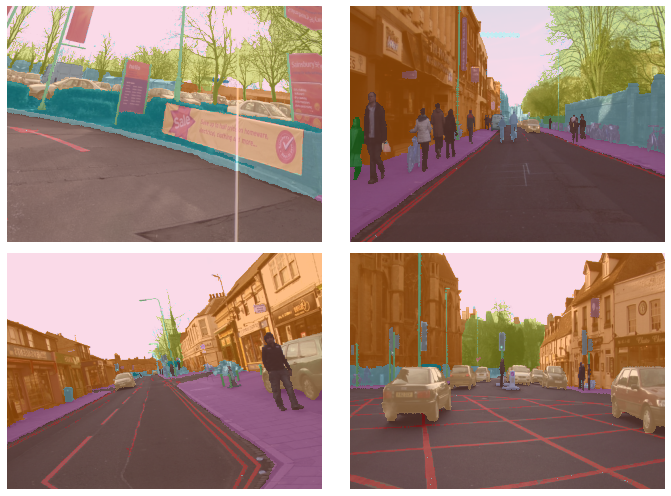

In [17]:
data.show_batch(2, figsize=(10,7)) #自动结合X和Y图，牛的

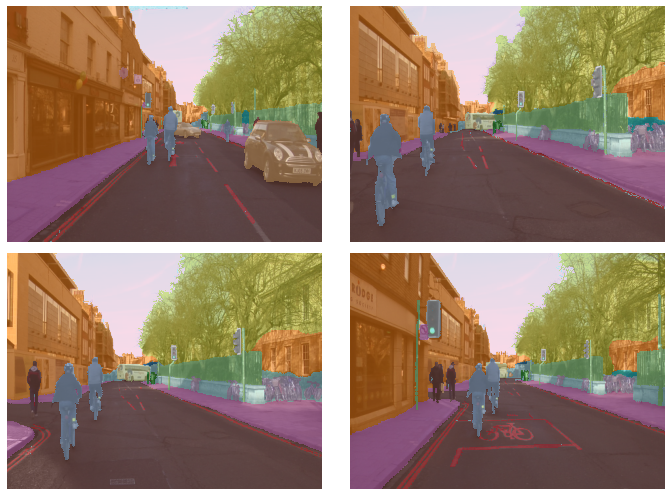

In [18]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [19]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [20]:
metrics=acc_camvid
# metrics=accuracy

In [21]:
wd=1e-2

In [22]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


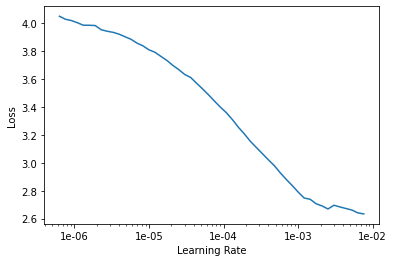

In [23]:
lr_find(learn)
learn.recorder.plot()

In [25]:
lr=3e-3

In [26]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.181023,0.790409,0.824361,01:29
1,0.803516,0.681270,0.822385,01:26
2,0.694111,0.516623,0.860577,01:26
3,0.611304,0.460798,0.875775,01:25
4,0.611829,0.455041,0.879087,01:25
5,0.584478,0.416742,0.877064,01:25
6,0.558683,0.461109,0.867440,01:24
7,0.627847,0.462332,0.872769,01:24
8,0.554740,0.399684,0.882675,01:24
9,0.463354,0.343697,0.896029,01:24


In [27]:
learn.save('stage-1')

In [28]:
learn.load('stage-1');

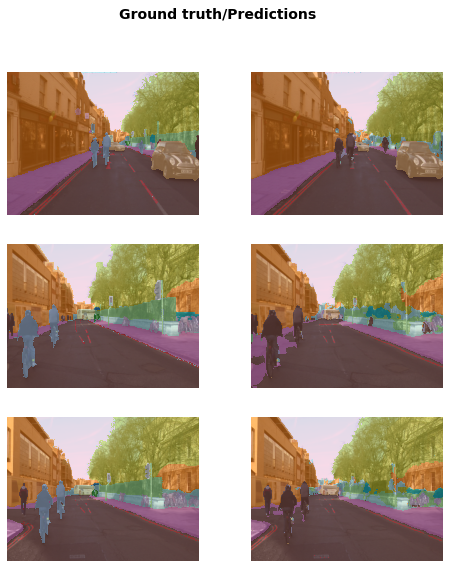

In [29]:
learn.show_results(rows=3, figsize=(8,9))

In [30]:
learn.unfreeze()

In [31]:
lrs = slice(lr/400,lr/4)

In [32]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.395617,0.331154,0.898692,01:28
1,0.391899,0.330005,0.899212,01:28
2,0.379295,0.319497,0.907144,01:28
3,0.370173,0.312370,0.912213,01:28
4,0.357206,0.305428,0.915784,01:28
5,0.348878,0.335457,0.905567,01:28
6,0.332327,0.311954,0.917212,01:28
7,0.320673,0.293021,0.920161,01:28
8,0.313414,0.310710,0.914933,01:28
9,0.300044,0.289438,0.923706,01:28


In [33]:
learn.save('stage-2');

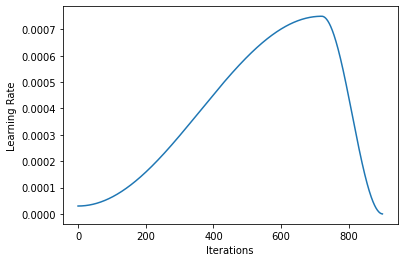

In [35]:
learn.recorder.plot_lr()  #学习率变小是不想让拟合的最后反复横跳，退火算法
#一开始不能用太大的学习率，因为模型可能直接向上飞了
#逐步增加lr增加了模型的可能性，使他不会只停留在非常bumpy的泛化能力很差的局部最优点
#而且事实上如果losses一直在下降，就可以适当提高一下最大学习率

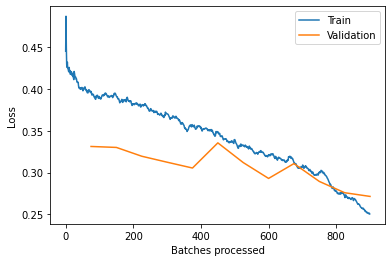

In [36]:
learn.recorder.plot_losses()

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [37]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=1, have 7717MB of GPU RAM free


In [38]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [39]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [40]:
learn.load('stage-2');

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


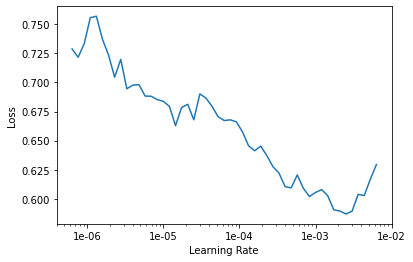

In [41]:
lr_find(learn)
learn.recorder.plot()

In [43]:
lr=1e-3

In [44]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.428996,0.305539,0.921179,05:31
1,0.377772,0.299305,0.922474,05:31
2,0.370552,0.306646,0.916622,05:31
3,0.384230,0.322917,0.914126,05:31
4,0.374725,0.342408,0.906658,05:30
5,0.414223,0.372888,0.918434,05:30
6,0.367671,0.276958,0.931565,05:30
7,0.318775,0.419956,0.909303,05:29
8,0.278894,0.270727,0.930296,05:29
9,0.242457,0.259600,0.931620,05:29


In [45]:
learn.save('stage-1-big')

In [46]:
learn.load('stage-1-big');

In [47]:
learn.unfreeze()

In [48]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.213867,0.260156,0.932961,05:45
1,0.225011,0.266831,0.930270,05:45
2,0.223195,0.253802,0.933684,05:45


In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

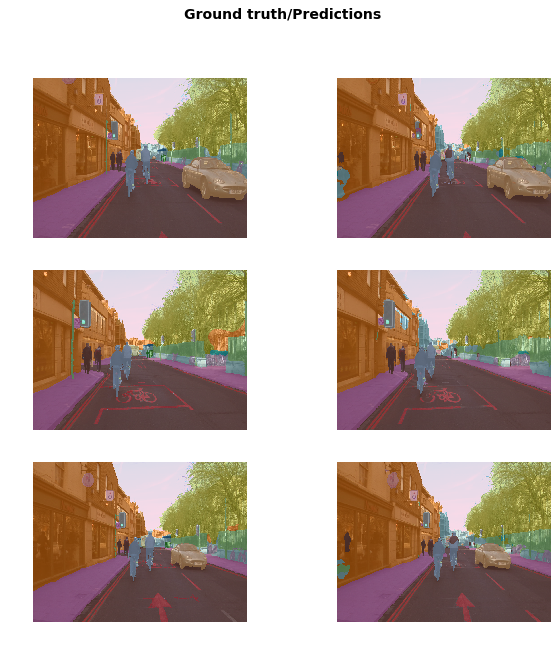

In [ ]:
learn.show_results(rows=3, figsize=(10,10))

## fin